## Project 1 - reccomender system

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import decomposition
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as st

1. Splitting the data into train and test set

In [29]:
df = pd.read_csv(r'ratings.csv')
print(df.loc[:,['userId','movieId']])

        userId  movieId
0            1        1
1            1        3
2            1        6
3            1       47
4            1       50
...        ...      ...
100831     610   166534
100832     610   168248
100833     610   168250
100834     610   168252
100835     610   170875

[100836 rows x 2 columns]


In [30]:
#Split into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(df.loc[:,['userId', 'movieId']], df.loc[:,'rating'], test_size=0.10, random_state=42)

X_train['rating'] = Y_train
X_train.to_csv('train_ratings.csv')

X_test['rating'] = Y_test
X_test.to_csv('test_ratings.csv')

print(X_train)

       userId  movieId  rating
14430      91     2431     2.0
43498     292      111     2.0
73590     474     1784     3.5
19181     124      110     3.5
97254     605     4899     2.5
...       ...      ...     ...
6265       42     4005     4.0
54886     364      141     4.0
76820     480     6867     4.0
860         6      981     3.0
15795     103     6711     5.0

[90752 rows x 3 columns]


In [35]:
#switching to numpy
df = df.to_numpy()
print(df.shape)
X = df[:,(0,1)]
Y = df[:,2]
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

(100836, 4)


In [32]:
#iterator for movieId values (to create matrix - not all values for movie ids are available)
n = len(set(X[:,0]))
d = len(set(X[:,1]))
print('Number of all ratings:',len(X[:,1]))
print('Number of movies:',d)
print('Number of all users:', n)
#print(np.arange(len(set(X[:,1]))).shape)
#print(sorted(list(set(X[:,1]))))
#print(sorted(set(X[:,1])))
#{sorted(set(X[:,1])): x for x in range(len(set(X[:,1])))}
#print(type(np.arange(len(set(X[:,1])))))
#print(np.arange(len(set(X[:,1]))))

iterator = np.transpose(np.vstack((sorted(list(set(X[:,1]))), np.arange(d))))
#dictionary -> movieId:assigned_sortedId
id_dict = {A: int(B) for A, B in zip(iterator[:,0], iterator[:,1])}
id_dict[2]
id_dict

Number of all ratings: 100836
Number of movies: 9724
Number of all users: 610


{1.0: 0,
 2.0: 1,
 3.0: 2,
 4.0: 3,
 5.0: 4,
 6.0: 5,
 7.0: 6,
 8.0: 7,
 9.0: 8,
 10.0: 9,
 11.0: 10,
 12.0: 11,
 13.0: 12,
 14.0: 13,
 15.0: 14,
 16.0: 15,
 17.0: 16,
 18.0: 17,
 19.0: 18,
 20.0: 19,
 21.0: 20,
 22.0: 21,
 23.0: 22,
 24.0: 23,
 25.0: 24,
 26.0: 25,
 27.0: 26,
 28.0: 27,
 29.0: 28,
 30.0: 29,
 31.0: 30,
 32.0: 31,
 34.0: 32,
 36.0: 33,
 38.0: 34,
 39.0: 35,
 40.0: 36,
 41.0: 37,
 42.0: 38,
 43.0: 39,
 44.0: 40,
 45.0: 41,
 46.0: 42,
 47.0: 43,
 48.0: 44,
 49.0: 45,
 50.0: 46,
 52.0: 47,
 53.0: 48,
 54.0: 49,
 55.0: 50,
 57.0: 51,
 58.0: 52,
 60.0: 53,
 61.0: 54,
 62.0: 55,
 63.0: 56,
 64.0: 57,
 65.0: 58,
 66.0: 59,
 68.0: 60,
 69.0: 61,
 70.0: 62,
 71.0: 63,
 72.0: 64,
 73.0: 65,
 74.0: 66,
 75.0: 67,
 76.0: 68,
 77.0: 69,
 78.0: 70,
 79.0: 71,
 80.0: 72,
 81.0: 73,
 82.0: 74,
 83.0: 75,
 85.0: 76,
 86.0: 77,
 87.0: 78,
 88.0: 79,
 89.0: 80,
 92.0: 81,
 93.0: 82,
 94.0: 83,
 95.0: 84,
 96.0: 85,
 97.0: 86,
 99.0: 87,
 100.0: 88,
 101.0: 89,
 102.0: 90,
 103.0: 91,
 10

In [203]:
#creating matrices Z and D

Z = np.zeros((n, d))
print(Z.shape)

for i in range(len(Y_train)):
    Z[int(X_train[i,0])-1,id_dict[X_train[i,1]]] = Y_train[i]
    
T = np.zeros((n, d))
for i in range(len(Y_test)):
    T[int(X_test[i,0])-1,id_dict[X_test[i,1]]] = Y_test[i]
    

(610, 9724)


Macierze Z i T są wypełnione zerami w miejscach gdzie nie ma oceny, w przypadku test (macierz T) nas to chyba nie obchodzi żeby to zmieniać a dla Z można łatwo zmienić.

In [148]:
#indexes of missing values in test set - we can use it to fill it differently than with 0s
filled_test = T!=0
filled_train = Z!=0

In [196]:
Z_mean = Z.copy()
Z_mean[Z==0] = np.mean(Z[Z!=0])

Z_mean_user = Z.copy()
for i in range(Z.shape[0]):
    Z_mean_user[i,Z[i,:]==0] = np.mean(Z[i,Z[i,:]!=0])
Z_mean_user[np.isnan(Z_mean_user)] = 3

Z_mean_movie = Z.copy()
for j in range(Z.shape[1]):
    Z_mean_movie[Z[:,j]==0,j] = np.mean(Z[Z[:,j]!=0,j])
Z_mean_movie[np.isnan(Z_mean_movie)] = 3

#najczęściej powtarzająca się ocena dla danego filmu, 
#funkcja mode nie działa dla pustego wektora - to się może zdarzyć jak wszystkie oceny z danego filmu trafiły do test set
#wstawiam wtedy 3 bo czemu nie - tak samo robię jak nie ma żadnej oceny dla danego użytownika albo filmu

Z_mode_movie = Z.copy()
for j in range(Z.shape[1]):
    try:
        Z_mode_movie[Z[:,j]==0,j] = st.mode(Z[Z[:,j]!=0,j])
    except:
        Z_mode_movie[Z[:,j]==0,j] = 3
        
#kombinacja średniej dla filmu (a) i średniej dla użytkownika (1-a)
a = 0.5
Z_comb = a*Z_mean_movie + (1-a)*Z_mean_user


C:\Users\Admin\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Admin\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [184]:
#print(Z[0,43])
##print(Z[0,46])
#print(Y_train)
#print(id_dict[47])
print(np.mean(Z[:,Z.shape[1]-1]))
print(Z_comb[:,110])
print(st.mode([2,2,3,3]))
(np.isnan(Z_comb)).any()

0.006557377049180328
[3.66666667 3.46296296 2.76470588 3.25634518 3.31395349 3.24731183
 3.12977099 3.34210526 3.14444444 3.11875    3.3852459  3.68518519
 3.30357143 3.17105263 3.21370968 3.37643678 3.60638298 3.36358696
 2.80417335 3.28393665 3.12992611 2.79772727 3.33181818 3.33823529
 3.89583333 3.125      3.29752066 3.01488095 3.56493506 3.86363636
 3.5        3.38020833 3.36940299 3.20192308 3.57142857 2.84
 3.55       3.0942029  3.51086957 3.39175258 3.14102564 3.2685422
 3.78061224 3.20731707 3.44859155 3.5125     3.01923077 3.5
 3.625      2.89760148 3.39307692 3.76096491 4.         3.03225806
 2.97727273 3.35897436 3.19565217 3.44791667 3.67010309 3.34210526
 3.51515152 3.53908555 3.31893004 3.38864629 3.50833333 3.52715655
 3.47142857 3.12256637 3.66666667 3.64622642 3.26785714 3.60119048
 3.37365591 3.63354037 3.12698413 3.03971963 3.46296296 3.07894737
 3.60909091 3.63064516 2.83333333 3.20487805 3.13095238 3.35192308
 3.328125   3.46641791 3.51388889 3.54591837 3.24624464

False

Quality of the system:

In [219]:
def RMSE(Z, T, filled_test):
    t = len(T[filled_test])
    return np.sqrt(sum((T[filled_test]- Z[filled_test])**2)/t)

# NMF

In [227]:
from  sklearn.decomposition  import NMF

def NMF_approximate(r, Z_matrix, nsteps = 1):
    RMSE_val = []
    model = NMF(n_components = r,  init = 'random' ,  random_state=0, max_iter=400)
    for i in range(nsteps):
        W = model.fit_transform(Z_matrix)
        H = model.components_
        Z_approximated = np.dot(W,H)
        Z_matrix[filled_train==False] = Z_approximated[filled_train==False]
        r_val = RMSE(Z_approximated, T, filled_test)
        RMSE_val.append(r_val)
    return Z_approximated, RMSE_val

In [223]:
Z_approx10, rmse = NMF_approximate(r, Z.copy(), 2)
rmse

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[3.013315793582092, 2.722639987069491]

In [224]:
print(Z)
print(Z_approx10)

[[4.  0.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  0.  ... 0.  0.  0. ]]
[[2.87814606e+00 1.68121809e+00 1.49278909e+00 ... 0.00000000e+00
  0.00000000e+00 1.75879881e-02]
 [5.56012772e-01 1.18035597e-01 0.00000000e+00 ... 1.01254333e-02
  1.01254333e-02 2.24723072e-02]
 [1.35789109e-01 5.84322068e-02 8.05322089e-02 ... 0.00000000e+00
  0.00000000e+00 5.66184210e-05]
 ...
 [3.48850716e+00 2.06776029e+00 1.71028066e+00 ... 0.00000000e+00
  0.00000000e+00 2.35960956e-02]
 [9.99101767e-01 1.32500586e+00 2.28787460e-01 ... 0.00000000e+00
  0.00000000e+00 1.66381399e-03]
 [4.83616323e+00 1.34907189e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00255952e-02]]


## Macierz wypełniona zerami

In [88]:
#to się liczy baaardzo długo, generalnie nawet dla ustalonego r to idzie jakoś super długo
one_step_NMF_filled_0 = []


for r in range(1,100):
    Z_approximated, RMSE_v = NMF_approximate(r,Z.copy())
    one_step_NMF_filled_0.append(RMSE_v)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\s

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\s

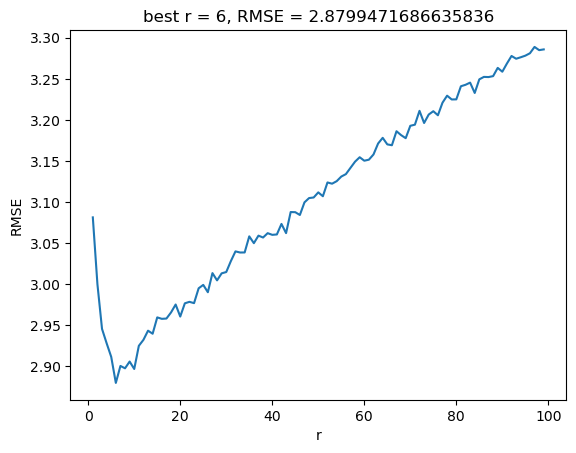

In [117]:
np.mean(one_step_NMF_filled_0)
plt.plot(range(1,100),one_step_NMF_filled_0)
plt.title(f"best r = {np.argmin(one_step_NMF_filled_0)+1}, RMSE = {np.min(one_step_NMF_filled_0)}")
plt.xlabel('r')
plt.ylabel("RMSE")
plt.show()

Teraz chcemy wybrać najlepsze r i zobaczyć o ile poprawi się RMSE jezeli powtórzymy więcej razy

In [185]:
NMF_more_steps_filled_0_r6 = []
r = np.argmin(one_step_NMF_filled_0) + 1
model = NMF(n_components = r,  init = 'random' ,  random_state=0)

copy_Z = Z.copy()
for k in range(1,100):
    W = model.fit_transform(copy_Z)
    H = model.components_
    Z_approximated = np.dot(W,H)
    copy_Z[filled_train==False] = Z_approximated[filled_train==False]
    NMF_more_steps_filled_0_r6.append(RMSE(Z_approximated, T, filled_test))


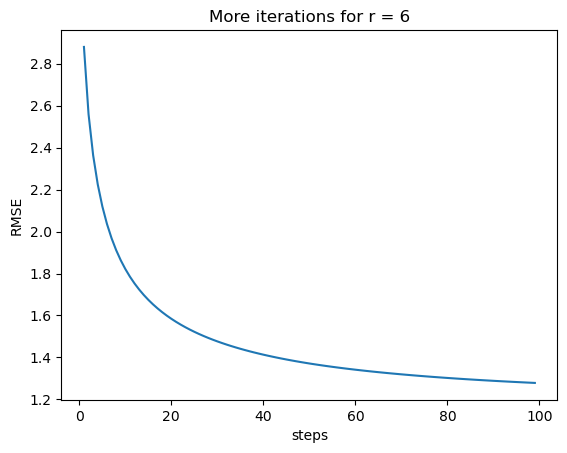

In [186]:
plt.plot(range(1,100), NMF_more_steps_filled_0_r6)
plt.title(f"More iterations for r = {r}")
plt.xlabel('steps')
plt.ylabel("RMSE")
plt.show()

Możemy powtórzyć te eksperymenty dla inaczej uzupełnionych macierzy, pierwszy przykład pokazał, że nie ma zbytnio sensu żeby próbować bardzo dużych wartości r, zawęzimy więc zakres poszukiwań od 1 do 30.  

Widzimy że im więcej kroków tym lepsze RMSE, w tym przypadku zostaniemy na razie przy 100.

In [225]:
def do_NFM_analysis(Z_matrix, r_max, NFM_iterations):
    outcoms_list = []
    one_step = []
    
    for r in range(1, r_max + 1):
        Z_approximated, RMSE_v = NMF_approximate(r,Z_matrix.copy())
        one_step.append(RMSE_v[0])
        
    plt.plot(range(1,r_max + 1),one_step)
    plt.title(f"best r = {np.argmin(one_step)+1}, RMSE = {np.min(one_step)}")
    plt.xlabel('r')
    plt.ylabel("RMSE")
    plt.show()
    
    r = np.argmin(one_step)+1
    #more steps
    more_steps_minr = []
    model = NMF(n_components = r,  init = 'random' ,  random_state=0)

    copy_Z = Z_matrix.copy()
    for k in range(1,NFM_iterations + 1):
        W = model.fit_transform(copy_Z)
        H = model.components_
        Z_approximated = np.dot(W,H)
        copy_Z[filled_train==False] = Z_approximated[filled_train==False]
        more_steps_minr.append(RMSE(Z_approximated, T, filled_test))
    
    plt.plot(range(1,NFM_iterations + 1), more_steps_minr)
    plt.title(f"More iterations for r = {r}")
    plt.xlabel('steps')
    plt.ylabel("RMSE")
    plt.show()

## Macierz ze średnią

In [187]:
one_step_NMF_filled_mean = []

for r in range(1,30):
    Z_approximated = NMF_approximate(r,Z)
    one_step_NMF_filled_mean.append(RMSE(Z_approximated, T, filled_test))

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\s

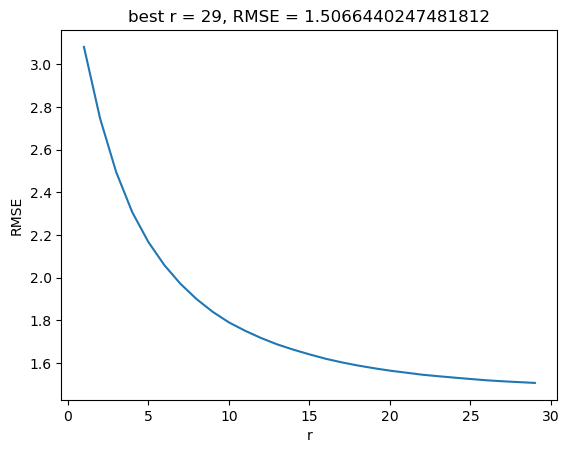

In [188]:
plt.plot(range(1,30),one_step_NMF_filled_mean)
plt.title(f"best r = {np.argmin(one_step_NMF_filled_mean)+1}, RMSE = {np.min(one_step_NMF_filled_mean)}")
plt.xlabel('r')
plt.ylabel("RMSE")
plt.show()

In [215]:
Z_mean

array([[4.        , 3.50255642, 4.        , ..., 3.50255642, 3.50255642,
        3.50255642],
       [3.50255642, 3.50255642, 3.50255642, ..., 3.50255642, 3.50255642,
        3.50255642],
       [3.50255642, 3.50255642, 3.50255642, ..., 3.50255642, 3.50255642,
        3.50255642],
       ...,
       [2.5       , 2.        , 2.        , ..., 3.50255642, 3.50255642,
        3.50255642],
       [3.        , 3.50255642, 3.50255642, ..., 3.50255642, 3.50255642,
        3.50255642],
       [5.        , 3.50255642, 3.50255642, ..., 3.50255642, 3.50255642,
        3.50255642]])

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\s

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\s

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\s

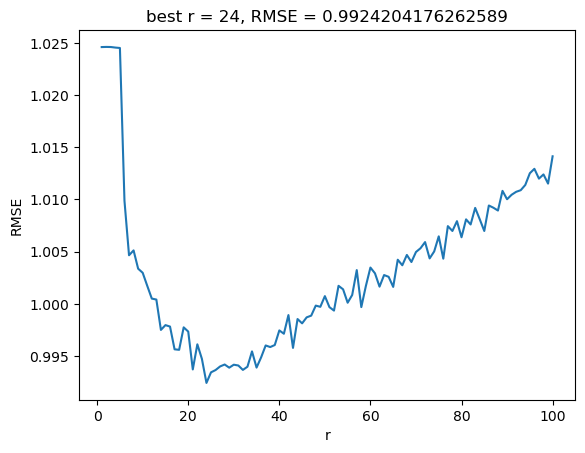

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\s

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\s

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\s

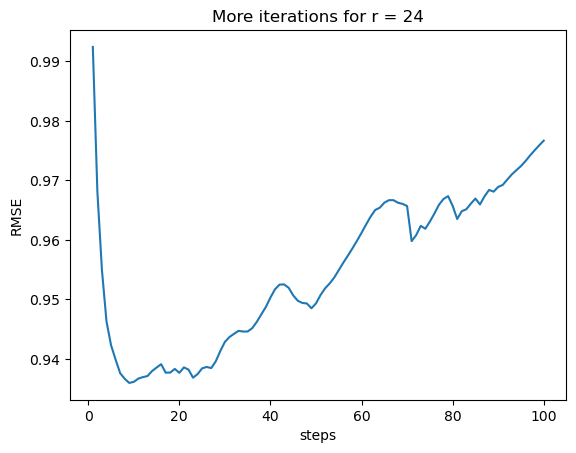

In [226]:
do_NFM_analysis(Z_mean, 100,100)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\s

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\s

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\s

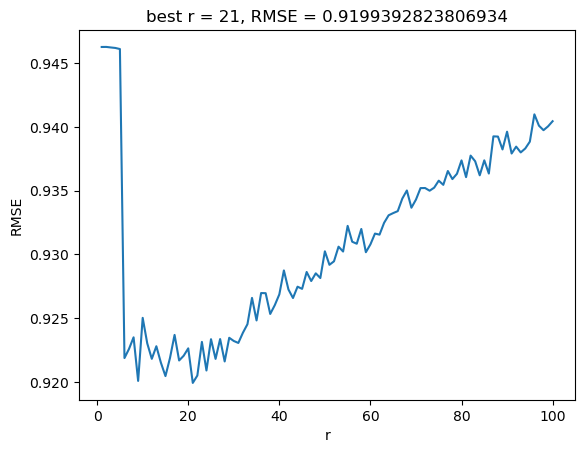

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\s

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\s

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\s

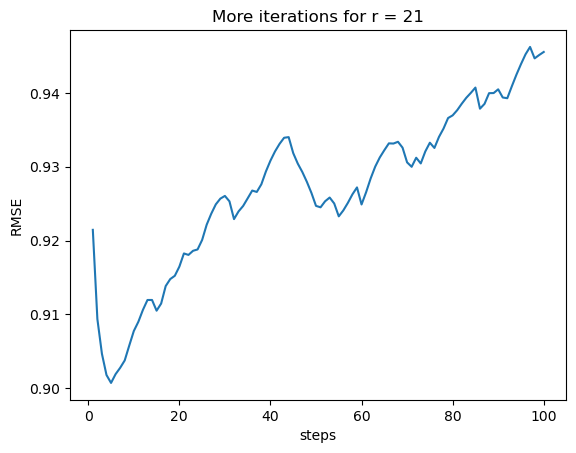

In [228]:
do_NFM_analysis(Z_mean_user, 100,100)

In [ ]:
do_NFM_analysis(Z_mean_movie, 100,100)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\s

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
do_NFM_analysis(Z_mode_movie, 100,100)

In [ ]:
do_NFM_analysis(Z_comb, 100,100)